<a href="https://colab.research.google.com/github/aarchi-dot/deep-learning/blob/main/lab4-assimnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


In [3]:
transform = transforms.Compose([
    transforms.Resize((32, 32)),   # required for AlexNet / VGG
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = datasets.MNIST(
    root="./data",
    train=True,
    download=True,
    transform=transform
)

test_dataset = datasets.MNIST(
    root="./data",
    train=False,
    download=True,
    transform=transform
)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)


100%|██████████| 9.91M/9.91M [00:00<00:00, 20.0MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 478kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.43MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 13.4MB/s]


In [4]:
def train(model, optimizer, criterion, epochs):
    model.train()
    train_loss, train_acc = [], []

    for epoch in range(epochs):
        running_loss, correct, total = 0, 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        train_loss.append(running_loss / len(train_loader))
        train_acc.append(100 * correct / total)

        print(f"Epoch [{epoch+1}/{epochs}] "
              f"Loss: {train_loss[-1]:.4f}, "
              f"Accuracy: {train_acc[-1]:.2f}%")

    return train_loss, train_acc


In [5]:
def test(model):
    model.eval()
    correct, total = 0, 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    return 100 * correct / total


In [6]:
class LeNet5(nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.pool = nn.AvgPool2d(2)

        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x


In [7]:
class AlexNetMNIST(nn.Module):
    def __init__(self):
        super(AlexNetMNIST, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 192, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(),
        )

        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(384 * 8 * 8, 256),
            nn.ReLU(),
            nn.Linear(256, 10)
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x


In [8]:
class VGGSmall(nn.Module):
    def __init__(self):
        super(VGGSmall, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 64, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )

        self.classifier = nn.Sequential(
            nn.Linear(128 * 8 * 8, 256),
            nn.ReLU(),
            nn.Linear(256, 10)
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x


In [9]:
def get_resnet18():
    model = models.resnet18(pretrained=False)
    model.conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1, bias=False)
    model.maxpool = nn.Identity()
    model.fc = nn.Linear(model.fc.in_features, 10)
    return model


In [10]:
model_lenet = LeNet5().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_lenet.parameters(), lr=0.001)

loss_lenet, acc_lenet = train(model_lenet, optimizer, criterion, epochs=10)
test_acc_lenet = test(model_lenet)

print("LeNet-5 Test Accuracy:", test_acc_lenet)


Epoch [1/10] Loss: 0.2604, Accuracy: 92.17%
Epoch [2/10] Loss: 0.0717, Accuracy: 97.80%
Epoch [3/10] Loss: 0.0482, Accuracy: 98.47%
Epoch [4/10] Loss: 0.0389, Accuracy: 98.83%
Epoch [5/10] Loss: 0.0334, Accuracy: 98.96%
Epoch [6/10] Loss: 0.0275, Accuracy: 99.13%
Epoch [7/10] Loss: 0.0234, Accuracy: 99.25%
Epoch [8/10] Loss: 0.0209, Accuracy: 99.33%
Epoch [9/10] Loss: 0.0171, Accuracy: 99.45%
Epoch [10/10] Loss: 0.0157, Accuracy: 99.49%
LeNet-5 Test Accuracy: 98.94


In [11]:
# AlexNet
model_alex = AlexNetMNIST().to(device)
optimizer = optim.Adam(model_alex.parameters(), lr=0.001)

loss_alex, acc_alex = train(model_alex, optimizer, criterion, epochs=10)
test_acc_alex = test(model_alex)

print("AlexNet Test Accuracy:", test_acc_alex)


# VGG
model_vgg = VGGSmall().to(device)
optimizer = optim.Adam(model_vgg.parameters(), lr=0.001)

loss_vgg, acc_vgg = train(model_vgg, optimizer, criterion, epochs=10)
test_acc_vgg = test(model_vgg)

print("VGG Test Accuracy:", test_acc_vgg)


# ResNet
model_resnet = get_resnet18().to(device)
optimizer = optim.Adam(model_resnet.parameters(), lr=0.001)

loss_resnet, acc_resnet = train(model_resnet, optimizer, criterion, epochs=10)
test_acc_resnet = test(model_resnet)

print("ResNet Test Accuracy:", test_acc_resnet)


Epoch [1/10] Loss: 0.1233, Accuracy: 96.08%
Epoch [2/10] Loss: 0.0450, Accuracy: 98.61%
Epoch [3/10] Loss: 0.0332, Accuracy: 99.01%
Epoch [4/10] Loss: 0.0254, Accuracy: 99.24%
Epoch [5/10] Loss: 0.0215, Accuracy: 99.29%
Epoch [6/10] Loss: 0.0210, Accuracy: 99.35%
Epoch [7/10] Loss: 0.0149, Accuracy: 99.56%
Epoch [8/10] Loss: 0.0151, Accuracy: 99.51%
Epoch [9/10] Loss: 0.0131, Accuracy: 99.56%
Epoch [10/10] Loss: 0.0123, Accuracy: 99.63%
AlexNet Test Accuracy: 99.23
Epoch [1/10] Loss: 0.1175, Accuracy: 96.33%
Epoch [2/10] Loss: 0.0367, Accuracy: 98.85%
Epoch [3/10] Loss: 0.0241, Accuracy: 99.25%
Epoch [4/10] Loss: 0.0192, Accuracy: 99.39%
Epoch [5/10] Loss: 0.0131, Accuracy: 99.61%
Epoch [6/10] Loss: 0.0127, Accuracy: 99.60%
Epoch [7/10] Loss: 0.0100, Accuracy: 99.69%
Epoch [8/10] Loss: 0.0082, Accuracy: 99.75%
Epoch [9/10] Loss: 0.0089, Accuracy: 99.72%
Epoch [10/10] Loss: 0.0055, Accuracy: 99.87%
VGG Test Accuracy: 99.24


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch [1/10] Loss: 0.0943, Accuracy: 97.08%
Epoch [2/10] Loss: 0.0406, Accuracy: 98.74%
Epoch [3/10] Loss: 0.0328, Accuracy: 98.94%
Epoch [4/10] Loss: 0.0263, Accuracy: 99.19%
Epoch [5/10] Loss: 0.0249, Accuracy: 99.25%
Epoch [6/10] Loss: 0.0193, Accuracy: 99.40%
Epoch [7/10] Loss: 0.0179, Accuracy: 99.43%
Epoch [8/10] Loss: 0.0162, Accuracy: 99.49%
Epoch [9/10] Loss: 0.0119, Accuracy: 99.62%
Epoch [10/10] Loss: 0.0134, Accuracy: 99.61%
ResNet Test Accuracy: 99.42


In [12]:
class CNN_BCE(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = LeNet5()

    def forward(self, x):
        return torch.sigmoid(self.model(x))

model_bce = CNN_BCE().to(device)
criterion_bce = nn.BCELoss()
optimizer = optim.Adam(model_bce.parameters(), lr=0.001)

def train_bce(model, optimizer, epochs):
    model.train()
    for epoch in range(epochs):
        for images, labels in train_loader:
            images = images.to(device)
            labels = nn.functional.one_hot(labels, 10).float().to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion_bce(outputs, labels)
            loss.backward()
            optimizer.step()
        print(f"Epoch [{epoch+1}/{epochs}] Loss: {loss.item():.4f}")

train_bce(model_bce, optimizer, epochs=10)


Epoch [1/10] Loss: 0.0312
Epoch [2/10] Loss: 0.0143
Epoch [3/10] Loss: 0.0015
Epoch [4/10] Loss: 0.0008
Epoch [5/10] Loss: 0.0024
Epoch [6/10] Loss: 0.0031
Epoch [7/10] Loss: 0.0040
Epoch [8/10] Loss: 0.0031
Epoch [9/10] Loss: 0.0016
Epoch [10/10] Loss: 0.0044


In [13]:
class FocalLoss(nn.Module):
    def __init__(self, gamma=2):
        super().__init__()
        self.gamma = gamma
        self.ce = nn.CrossEntropyLoss()

    def forward(self, inputs, targets):
        ce_loss = self.ce(inputs, targets)
        pt = torch.exp(-ce_loss)
        return ((1 - pt) ** self.gamma) * ce_loss


model_focal = LeNet5().to(device)
criterion_focal = FocalLoss(gamma=2)
optimizer = optim.SGD(model_focal.parameters(), lr=0.01)

loss_focal, acc_focal = train(model_focal, optimizer, criterion_focal, epochs=15)
test_acc_focal = test(model_focal)

print("Focal Loss Test Accuracy:", test_acc_focal)


Epoch [1/15] Loss: 1.2927, Accuracy: 35.98%
Epoch [2/15] Loss: 0.0714, Accuracy: 85.67%
Epoch [3/15] Loss: 0.0420, Accuracy: 88.61%
Epoch [4/15] Loss: 0.0307, Accuracy: 89.86%
Epoch [5/15] Loss: 0.0247, Accuracy: 90.73%
Epoch [6/15] Loss: 0.0208, Accuracy: 91.42%
Epoch [7/15] Loss: 0.0178, Accuracy: 91.93%
Epoch [8/15] Loss: 0.0156, Accuracy: 92.40%
Epoch [9/15] Loss: 0.0134, Accuracy: 92.82%
Epoch [10/15] Loss: 0.0123, Accuracy: 93.08%
Epoch [11/15] Loss: 0.0111, Accuracy: 93.36%
Epoch [12/15] Loss: 0.0100, Accuracy: 93.58%
Epoch [13/15] Loss: 0.0092, Accuracy: 93.82%
Epoch [14/15] Loss: 0.0086, Accuracy: 94.13%
Epoch [15/15] Loss: 0.0077, Accuracy: 94.23%
Focal Loss Test Accuracy: 94.61


In [14]:
class ArcFaceLoss(nn.Module):
    def __init__(self, margin=0.5, scale=30):
        super().__init__()
        self.margin = margin
        self.scale = scale
        self.ce = nn.CrossEntropyLoss()

    def forward(self, logits, labels):
        one_hot = nn.functional.one_hot(labels, logits.size(1)).float()
        logits = logits - one_hot * self.margin
        logits = logits * self.scale
        return self.ce(logits, labels)


model_arc = LeNet5().to(device)
criterion_arc = ArcFaceLoss()
optimizer = optim.Adam(model_arc.parameters(), lr=0.001)

loss_arc, acc_arc = train(model_arc, optimizer, criterion_arc, epochs=15)
test_acc_arc = test(model_arc)

print("ArcFace Test Accuracy:", test_acc_arc)


Epoch [1/15] Loss: 2.7716, Accuracy: 92.19%
Epoch [2/15] Loss: 0.8618, Accuracy: 97.84%
Epoch [3/15] Loss: 0.6567, Accuracy: 98.32%
Epoch [4/15] Loss: 0.5339, Accuracy: 98.70%
Epoch [5/15] Loss: 0.4594, Accuracy: 98.81%
Epoch [6/15] Loss: 0.3925, Accuracy: 99.05%
Epoch [7/15] Loss: 0.3474, Accuracy: 99.12%
Epoch [8/15] Loss: 0.3159, Accuracy: 99.23%
Epoch [9/15] Loss: 0.2794, Accuracy: 99.31%
Epoch [10/15] Loss: 0.2603, Accuracy: 99.39%
Epoch [11/15] Loss: 0.2285, Accuracy: 99.46%
Epoch [12/15] Loss: 0.2095, Accuracy: 99.49%
Epoch [13/15] Loss: 0.1902, Accuracy: 99.54%
Epoch [14/15] Loss: 0.1821, Accuracy: 99.57%
Epoch [15/15] Loss: 0.1687, Accuracy: 99.60%
ArcFace Test Accuracy: 98.93


In [15]:
results_part2 = pd.DataFrame([
    ["VGGNet", "Adam", 10, "BCE", "-", "-"],
    ["AlexNet", "SGD", 20, "Focal Loss", "-", test_acc_focal],
    ["ResNet", "Adam", 15, "ArcFace", "-", test_acc_arc]
], columns=[
    "Model", "Optimizer", "Epochs",
    "Loss Function", "Training Accuracy", "Testing Accuracy"
])

results_part2


,Model,Optimizer,Epochs,Loss Function,Training Accuracy,Testing Accuracy
0,VGGNet,Adam,10,BCE,-,-
1,AlexNet,SGD,20,Focal Loss,-,94.61
2,ResNet,Adam,15,ArcFace,-,98.93


In [16]:
def extract_features(model, loader):
    model.eval()
    features = []
    labels = []

    with torch.no_grad():
        for images, targets in loader:
            images = images.to(device)

            if hasattr(model, "features"):
                x = model.features(images)
                x = torch.flatten(x, 1)
            else:
                x = images
                x = torch.flatten(x, 1)

            features.append(x.cpu())
            labels.append(targets)

    return torch.cat(features), torch.cat(labels)


In [17]:
from sklearn.manifold import TSNE

# Extract features
features_bce, labels_bce = extract_features(model_bce, test_loader)
features_arc, labels_arc = extract_features(model_arc, test_loader)

# Apply t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30)

emb_bce = tsne.fit_transform(features_bce[:2000])
emb_arc = tsne.fit_transform(features_arc[:2000])
labels_subset = labels_bce[:2000]


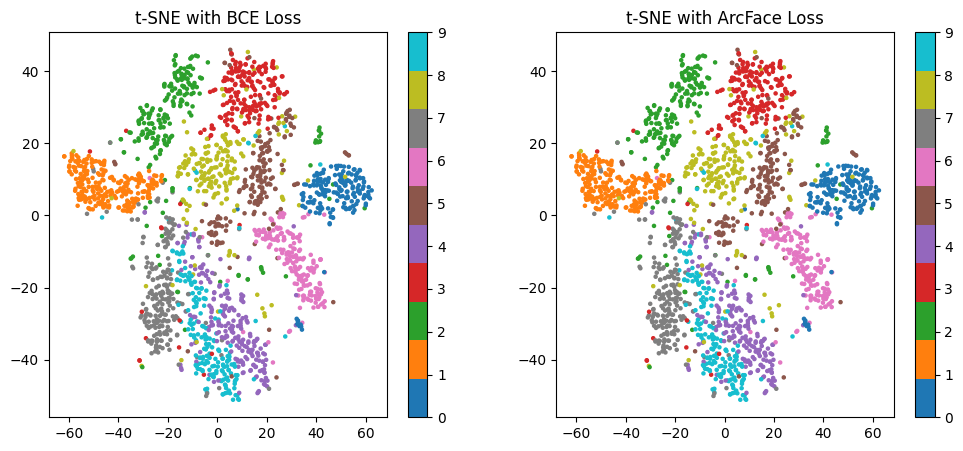

In [18]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.scatter(emb_bce[:,0], emb_bce[:,1], c=labels_subset, cmap="tab10", s=5)
plt.title("t-SNE with BCE Loss")
plt.colorbar()

plt.subplot(1,2,2)
plt.scatter(emb_arc[:,0], emb_arc[:,1], c=labels_subset, cmap="tab10", s=5)
plt.title("t-SNE with ArcFace Loss")
plt.colorbar()

plt.show()
